In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/heart-disease-uci/heart.csv


In [2]:
heart_df = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')

1. no null values in data

In [3]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


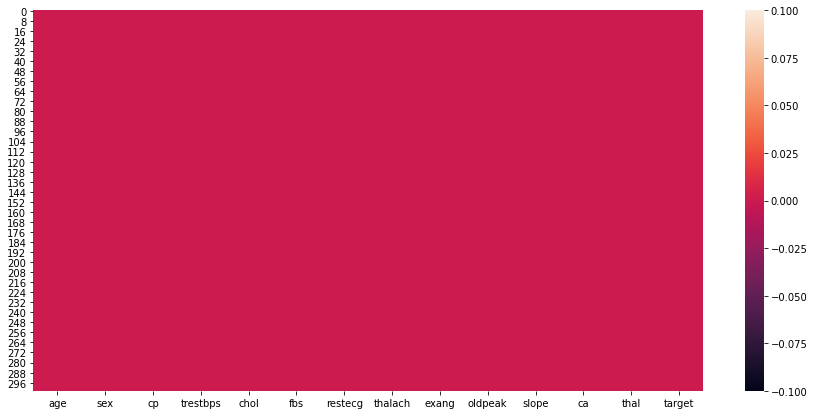

In [4]:
plt.figure(figsize=(15, 7))
sns.heatmap(heart_df.isnull())

In [5]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## columns

1.  ageage in years
2.  sex(1 = male; 0 = female)
3.  cpchest pain type
4.  trestbpsresting blood pressure (in mm Hg on admission to the hospital)
5.  cholserum cholestoral in mg/dl
6.  fbs(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7.  restecgresting electrocardiographic results
8.  thalachmaximum heart rate achieved
9.  exangexercise induced angina (1 = yes; 0 = no)
10. oldpeakST depression induced by exercise relative to rest
11. slopethe slope of the peak exercise ST segment
12. canumber of major vessels (0-3) colored by flourosopy
13. thal3 = normal; 6 = fixed defect; 7 = reversable defect
14. target 1 or 0

### ** target distribution**
* more positive case then negative case on dataset

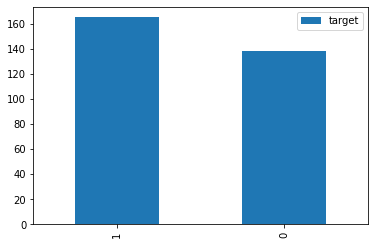

In [9]:
heart_df['target'].value_counts().plot(kind = 'bar')
plt.legend()

In [10]:
def drawKdePlot(df, col):
    plt.figure(figsize=(15, 7))
    df = pd.DataFrame({'positive':heart_df[heart_df['target'] == 1][col],'negative':heart_df[heart_df['target']==0][col]})
    sns.kdeplot(df['positive'], shade = True)
    sns.kdeplot(df['negative'], shade = True)    

In [24]:
def drawbarChart(df, col):
    df = df.groupby(col).agg({'target':['sum']})
    df.columns = ['target']
    df.plot(kind = 'bar', figsize = (15, 7))    
    plt.legend()

## Age distribution

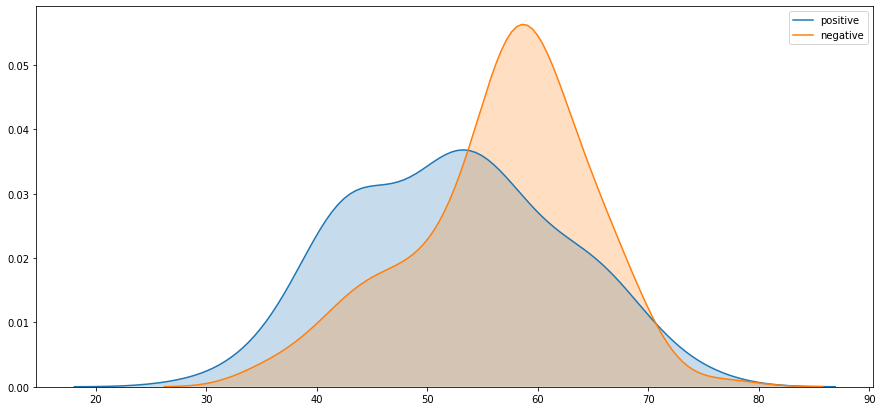

In [25]:
drawKdePlot(heart_df, 'age')

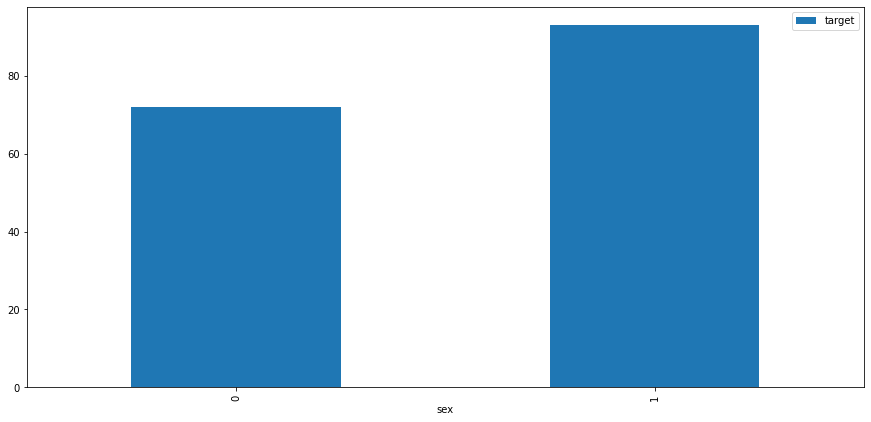

In [26]:
drawbarChart(heart_df, 'sex')

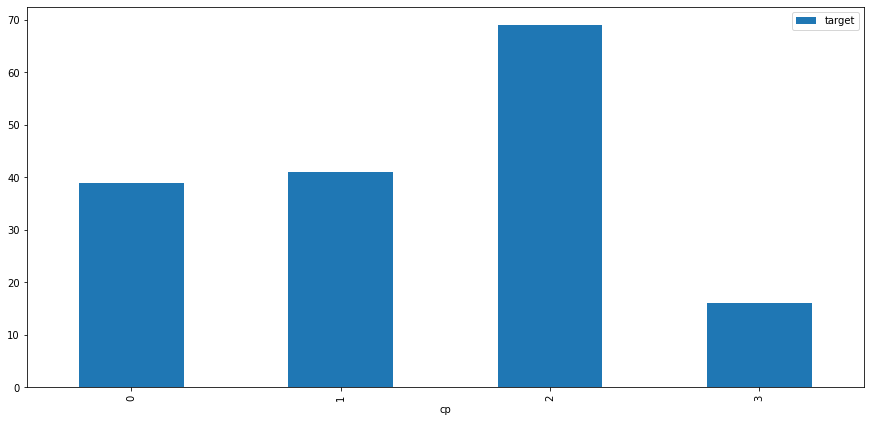

In [27]:
drawbarChart(heart_df, 'cp')

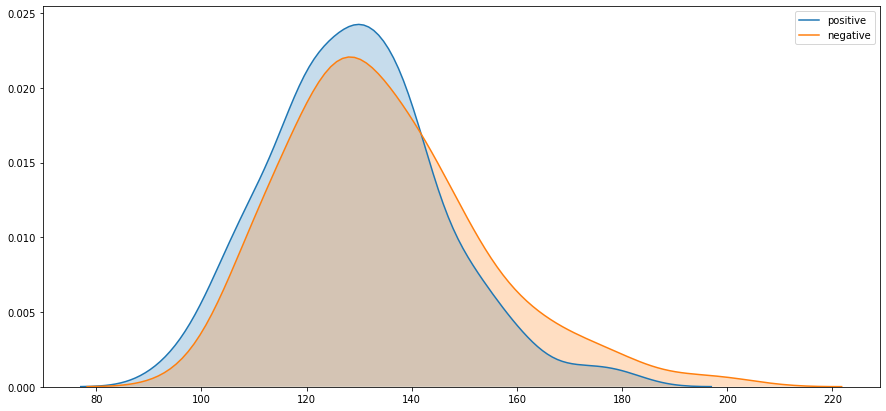

In [28]:
drawKdePlot(heart_df, 'trestbps')

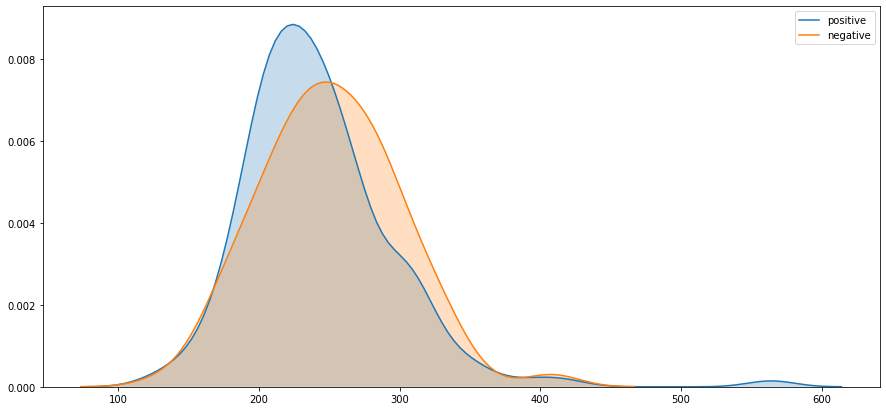

In [29]:
drawKdePlot(heart_df, 'chol')

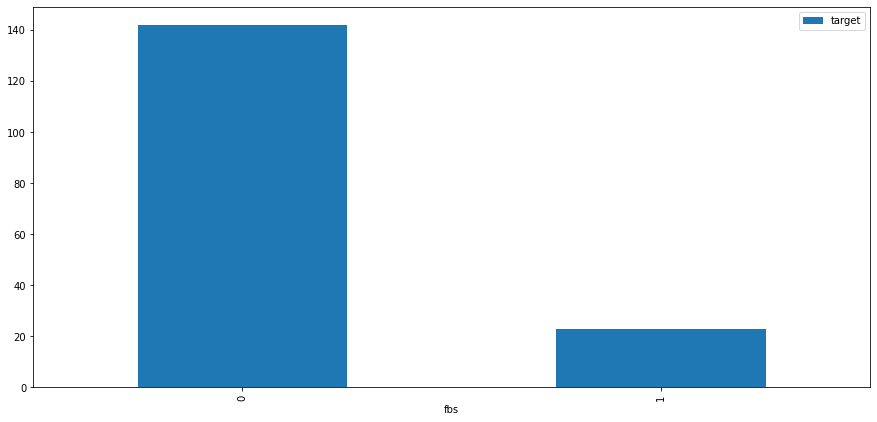

In [30]:
drawbarChart(heart_df, 'fbs')

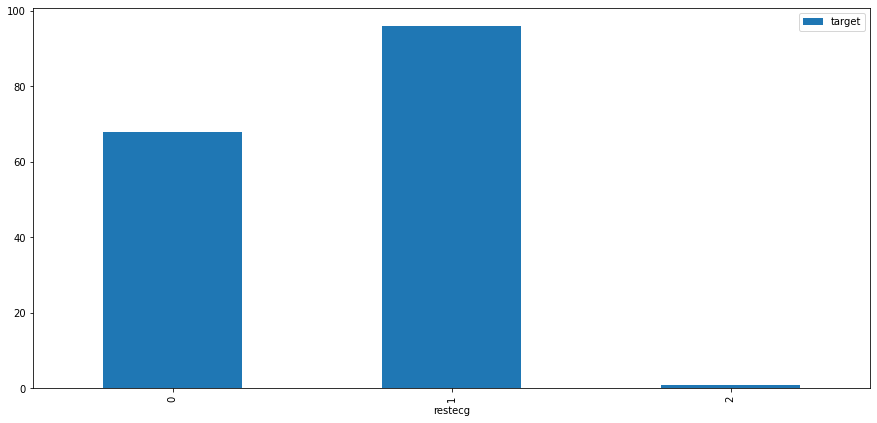

In [31]:
drawbarChart(heart_df, 'restecg')

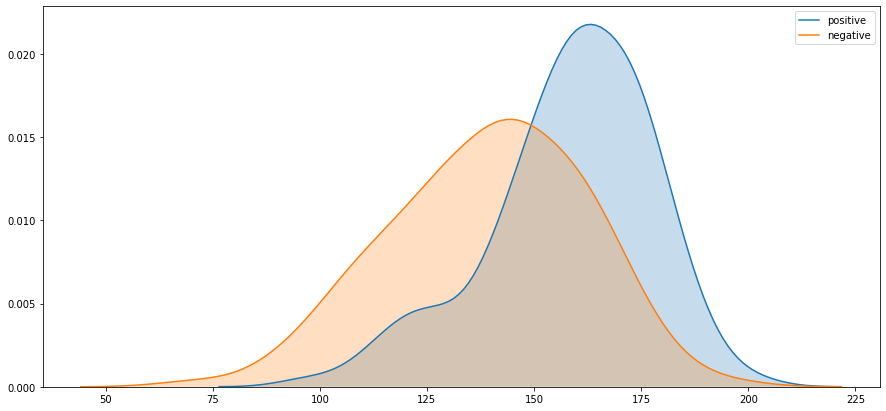

In [19]:
drawKdePlot(heart_df, 'thalach')

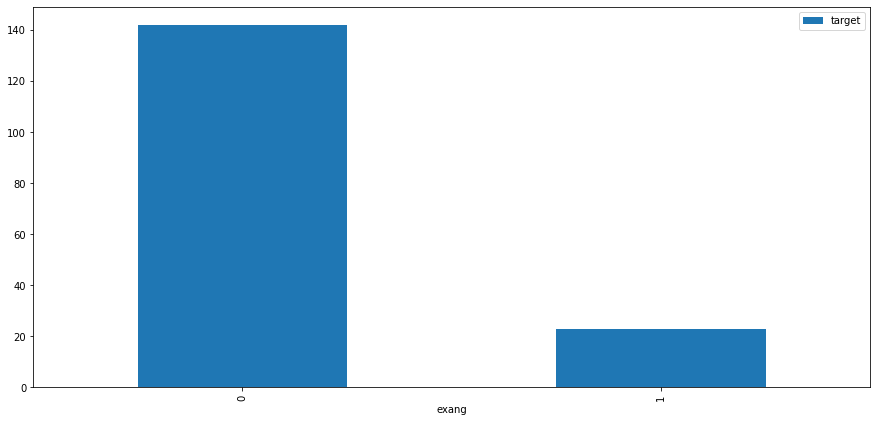

In [20]:
drawbarChart(heart_df, 'exang')

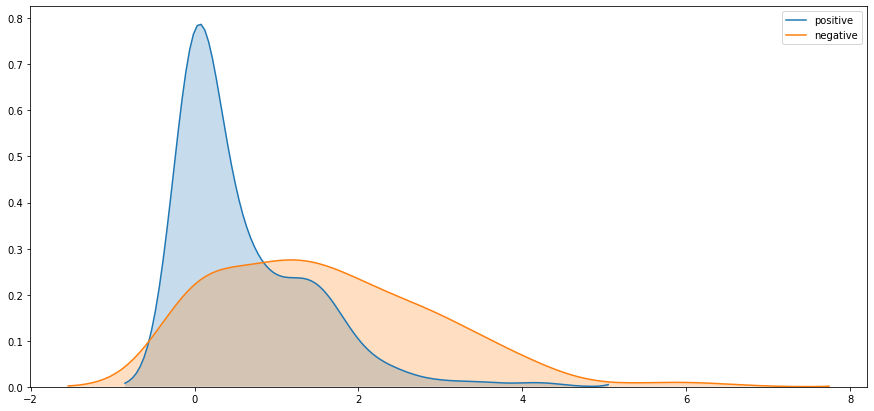

In [21]:
drawKdePlot(heart_df, 'oldpeak')

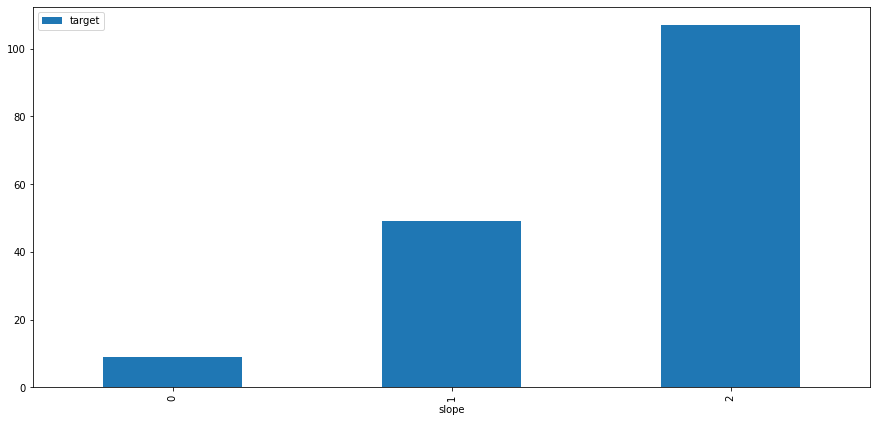

In [22]:
drawbarChart(heart_df, 'slope')

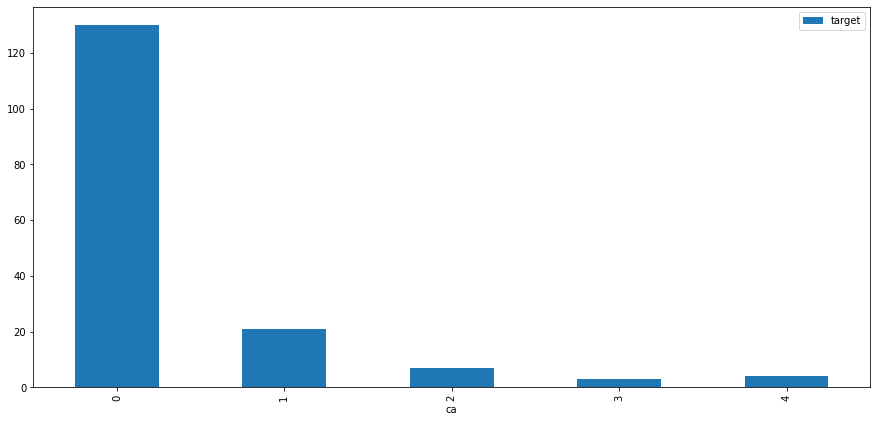

In [23]:
drawbarChart(heart_df, 'ca')

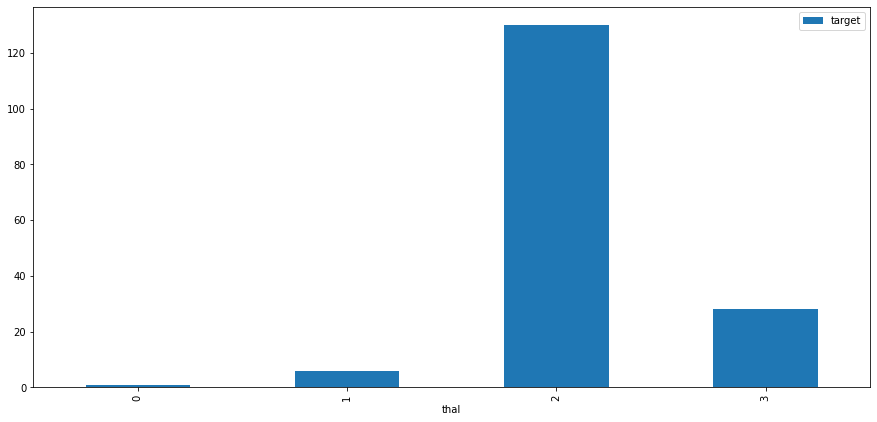

In [32]:
drawbarChart(heart_df, 'thal')

In [33]:
heart_df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [34]:
for col in heart_df:
    print('{} unique value: {}'.format(col, len(heart_df[col].unique())))

age unique value: 41
sex unique value: 2
cp unique value: 4
trestbps unique value: 49
chol unique value: 152
fbs unique value: 2
restecg unique value: 3
thalach unique value: 91
exang unique value: 2
oldpeak unique value: 40
slope unique value: 3
ca unique value: 5
thal unique value: 4
target unique value: 2


In [35]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
continous_columns   = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [36]:
def meanEncoding(df, col):
    df_1 = df.groupby(col).agg({'target' : ['mean']}).reset_index()
    mean_col = col + '_mean_encode'
    df_1.columns = [col, mean_col]
    df = df.merge(df_1, on = col, how = 'left')
    df.drop([col], inplace = True, axis = 1)
    return df

In [37]:
heart_df = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')
for col in categorical_columns:
       heart_df = meanEncoding(heart_df, col)

# Modeling

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [39]:
train  = heart_df.drop(['target'], axis = 1)
target = heart_df['target']

X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size = 0.3, shuffle = True, random_state = 7)

# SVM

In [40]:
svm = SVC()

In [41]:
cross_val_score(svm , train, target, cv = 3)

array([0.59405941, 0.69306931, 0.6039604 ])

# XGBClassifier

In [44]:
xgb = XGBClassifier(n_estimator = 1000)

In [45]:
cross_val_score(xgb , train, target, cv = 3)

array([0.87128713, 0.77227723, 0.78217822])

# CatBoostClassifier

In [46]:
catboost = CatBoostClassifier()

In [47]:
cross_val_score(catboost , train, target, cv = 3)

Learning rate set to 0.005204
0:	learn: 0.6885002	total: 52.8ms	remaining: 52.8s
1:	learn: 0.6840994	total: 53.6ms	remaining: 26.8s
2:	learn: 0.6804283	total: 54.5ms	remaining: 18.1s
3:	learn: 0.6759459	total: 55.2ms	remaining: 13.7s
4:	learn: 0.6726144	total: 55.9ms	remaining: 11.1s
5:	learn: 0.6698045	total: 56.6ms	remaining: 9.37s
6:	learn: 0.6666466	total: 57.3ms	remaining: 8.12s
7:	learn: 0.6637107	total: 57.7ms	remaining: 7.16s
8:	learn: 0.6602886	total: 58.4ms	remaining: 6.43s
9:	learn: 0.6571233	total: 59ms	remaining: 5.84s
10:	learn: 0.6531781	total: 59.7ms	remaining: 5.36s
11:	learn: 0.6495158	total: 60.3ms	remaining: 4.96s
12:	learn: 0.6474381	total: 61ms	remaining: 4.63s
13:	learn: 0.6430956	total: 61.8ms	remaining: 4.35s
14:	learn: 0.6391706	total: 62.4ms	remaining: 4.1s
15:	learn: 0.6356081	total: 63.2ms	remaining: 3.88s
16:	learn: 0.6319442	total: 63.9ms	remaining: 3.69s
17:	learn: 0.6306897	total: 64.3ms	remaining: 3.5s
18:	learn: 0.6279273	total: 65ms	remaining: 3.36s


176:	learn: 0.3453654	total: 182ms	remaining: 845ms
177:	learn: 0.3442525	total: 183ms	remaining: 844ms
178:	learn: 0.3434433	total: 184ms	remaining: 843ms
179:	learn: 0.3423602	total: 184ms	remaining: 840ms
180:	learn: 0.3413694	total: 185ms	remaining: 838ms
181:	learn: 0.3407241	total: 186ms	remaining: 835ms
182:	learn: 0.3397565	total: 187ms	remaining: 833ms
183:	learn: 0.3386493	total: 187ms	remaining: 830ms
184:	learn: 0.3379178	total: 188ms	remaining: 828ms
185:	learn: 0.3372098	total: 189ms	remaining: 826ms
186:	learn: 0.3363535	total: 189ms	remaining: 823ms
187:	learn: 0.3357201	total: 190ms	remaining: 821ms
188:	learn: 0.3349135	total: 191ms	remaining: 818ms
189:	learn: 0.3339805	total: 191ms	remaining: 816ms
190:	learn: 0.3329341	total: 192ms	remaining: 814ms
191:	learn: 0.3318156	total: 193ms	remaining: 812ms
192:	learn: 0.3308014	total: 194ms	remaining: 809ms
193:	learn: 0.3299601	total: 194ms	remaining: 807ms
194:	learn: 0.3295645	total: 195ms	remaining: 805ms
195:	learn: 

424:	learn: 0.2033921	total: 360ms	remaining: 487ms
425:	learn: 0.2030316	total: 361ms	remaining: 486ms
426:	learn: 0.2026345	total: 362ms	remaining: 485ms
427:	learn: 0.2023047	total: 362ms	remaining: 484ms
428:	learn: 0.2018567	total: 363ms	remaining: 483ms
429:	learn: 0.2015982	total: 364ms	remaining: 482ms
430:	learn: 0.2012491	total: 365ms	remaining: 481ms
431:	learn: 0.2009330	total: 365ms	remaining: 480ms
432:	learn: 0.2004283	total: 366ms	remaining: 479ms
433:	learn: 0.2004127	total: 366ms	remaining: 478ms
434:	learn: 0.2001256	total: 367ms	remaining: 477ms
435:	learn: 0.1996405	total: 368ms	remaining: 476ms
436:	learn: 0.1992582	total: 368ms	remaining: 475ms
437:	learn: 0.1989536	total: 369ms	remaining: 473ms
438:	learn: 0.1985962	total: 370ms	remaining: 472ms
439:	learn: 0.1981710	total: 370ms	remaining: 471ms
440:	learn: 0.1978803	total: 371ms	remaining: 470ms
441:	learn: 0.1973864	total: 372ms	remaining: 469ms
442:	learn: 0.1969179	total: 372ms	remaining: 468ms
443:	learn: 

667:	learn: 0.1382790	total: 537ms	remaining: 267ms
668:	learn: 0.1380617	total: 539ms	remaining: 266ms
669:	learn: 0.1379306	total: 539ms	remaining: 266ms
670:	learn: 0.1377012	total: 540ms	remaining: 265ms
671:	learn: 0.1375888	total: 541ms	remaining: 264ms
672:	learn: 0.1373240	total: 541ms	remaining: 263ms
673:	learn: 0.1371623	total: 542ms	remaining: 262ms
674:	learn: 0.1369811	total: 543ms	remaining: 261ms
675:	learn: 0.1367759	total: 544ms	remaining: 261ms
676:	learn: 0.1366122	total: 544ms	remaining: 260ms
677:	learn: 0.1364383	total: 545ms	remaining: 259ms
678:	learn: 0.1361683	total: 546ms	remaining: 258ms
679:	learn: 0.1360314	total: 547ms	remaining: 257ms
680:	learn: 0.1358960	total: 547ms	remaining: 256ms
681:	learn: 0.1357665	total: 548ms	remaining: 256ms
682:	learn: 0.1355467	total: 549ms	remaining: 255ms
683:	learn: 0.1353291	total: 550ms	remaining: 254ms
684:	learn: 0.1350826	total: 550ms	remaining: 253ms
685:	learn: 0.1349136	total: 551ms	remaining: 252ms
686:	learn: 

908:	learn: 0.0991917	total: 714ms	remaining: 71.5ms
909:	learn: 0.0990699	total: 715ms	remaining: 70.8ms
910:	learn: 0.0989416	total: 716ms	remaining: 70ms
911:	learn: 0.0987923	total: 717ms	remaining: 69.2ms
912:	learn: 0.0987529	total: 718ms	remaining: 68.4ms
913:	learn: 0.0986200	total: 718ms	remaining: 67.6ms
914:	learn: 0.0985159	total: 719ms	remaining: 66.8ms
915:	learn: 0.0983551	total: 720ms	remaining: 66ms
916:	learn: 0.0982241	total: 721ms	remaining: 65.2ms
917:	learn: 0.0981031	total: 721ms	remaining: 64.4ms
918:	learn: 0.0979476	total: 722ms	remaining: 63.6ms
919:	learn: 0.0978034	total: 723ms	remaining: 62.9ms
920:	learn: 0.0976455	total: 724ms	remaining: 62.1ms
921:	learn: 0.0974633	total: 724ms	remaining: 61.3ms
922:	learn: 0.0973340	total: 725ms	remaining: 60.5ms
923:	learn: 0.0971878	total: 726ms	remaining: 59.7ms
924:	learn: 0.0970459	total: 727ms	remaining: 58.9ms
925:	learn: 0.0969860	total: 727ms	remaining: 58.1ms
926:	learn: 0.0967999	total: 728ms	remaining: 57.3

95:	learn: 0.4419861	total: 69.1ms	remaining: 650ms
96:	learn: 0.4410383	total: 69.7ms	remaining: 649ms
97:	learn: 0.4392508	total: 70.5ms	remaining: 649ms
98:	learn: 0.4374830	total: 71.3ms	remaining: 649ms
99:	learn: 0.4359463	total: 72.1ms	remaining: 649ms
100:	learn: 0.4345347	total: 72.8ms	remaining: 648ms
101:	learn: 0.4333348	total: 73.6ms	remaining: 648ms
102:	learn: 0.4319692	total: 74.4ms	remaining: 648ms
103:	learn: 0.4302380	total: 75.1ms	remaining: 647ms
104:	learn: 0.4287734	total: 75.7ms	remaining: 646ms
105:	learn: 0.4271528	total: 76.4ms	remaining: 644ms
106:	learn: 0.4253161	total: 77.1ms	remaining: 643ms
107:	learn: 0.4235574	total: 77.7ms	remaining: 642ms
108:	learn: 0.4217472	total: 78.4ms	remaining: 641ms
109:	learn: 0.4201522	total: 79.1ms	remaining: 640ms
110:	learn: 0.4185363	total: 79.8ms	remaining: 639ms
111:	learn: 0.4177034	total: 80.5ms	remaining: 638ms
112:	learn: 0.4157086	total: 81.2ms	remaining: 638ms
113:	learn: 0.4144951	total: 81.9ms	remaining: 637m

344:	learn: 0.2340953	total: 246ms	remaining: 468ms
345:	learn: 0.2334589	total: 247ms	remaining: 468ms
346:	learn: 0.2331144	total: 248ms	remaining: 467ms
347:	learn: 0.2325769	total: 249ms	remaining: 467ms
348:	learn: 0.2319745	total: 250ms	remaining: 466ms
349:	learn: 0.2316784	total: 250ms	remaining: 465ms
350:	learn: 0.2315817	total: 251ms	remaining: 464ms
351:	learn: 0.2312355	total: 252ms	remaining: 463ms
352:	learn: 0.2307306	total: 252ms	remaining: 462ms
353:	learn: 0.2303687	total: 253ms	remaining: 462ms
354:	learn: 0.2298381	total: 254ms	remaining: 461ms
355:	learn: 0.2294095	total: 254ms	remaining: 460ms
356:	learn: 0.2290577	total: 255ms	remaining: 459ms
357:	learn: 0.2285304	total: 256ms	remaining: 459ms
358:	learn: 0.2282504	total: 256ms	remaining: 458ms
359:	learn: 0.2280684	total: 257ms	remaining: 457ms
360:	learn: 0.2276867	total: 258ms	remaining: 456ms
361:	learn: 0.2273238	total: 258ms	remaining: 456ms
362:	learn: 0.2267938	total: 259ms	remaining: 455ms
363:	learn: 

598:	learn: 0.1605661	total: 423ms	remaining: 283ms
599:	learn: 0.1602134	total: 424ms	remaining: 283ms
600:	learn: 0.1601377	total: 425ms	remaining: 282ms
601:	learn: 0.1598609	total: 426ms	remaining: 281ms
602:	learn: 0.1596863	total: 426ms	remaining: 281ms
603:	learn: 0.1594598	total: 427ms	remaining: 280ms
604:	learn: 0.1592390	total: 428ms	remaining: 279ms
605:	learn: 0.1590225	total: 429ms	remaining: 279ms
606:	learn: 0.1587674	total: 429ms	remaining: 278ms
607:	learn: 0.1585303	total: 430ms	remaining: 277ms
608:	learn: 0.1582668	total: 431ms	remaining: 277ms
609:	learn: 0.1580543	total: 432ms	remaining: 276ms
610:	learn: 0.1579005	total: 432ms	remaining: 275ms
611:	learn: 0.1577397	total: 433ms	remaining: 275ms
612:	learn: 0.1576062	total: 434ms	remaining: 274ms
613:	learn: 0.1573629	total: 435ms	remaining: 273ms
614:	learn: 0.1570971	total: 436ms	remaining: 273ms
615:	learn: 0.1568893	total: 436ms	remaining: 272ms
616:	learn: 0.1565416	total: 437ms	remaining: 271ms
617:	learn: 

841:	learn: 0.1192045	total: 600ms	remaining: 113ms
842:	learn: 0.1190771	total: 601ms	remaining: 112ms
843:	learn: 0.1189959	total: 602ms	remaining: 111ms
844:	learn: 0.1188987	total: 603ms	remaining: 111ms
845:	learn: 0.1188095	total: 603ms	remaining: 110ms
846:	learn: 0.1186661	total: 604ms	remaining: 109ms
847:	learn: 0.1185208	total: 605ms	remaining: 108ms
848:	learn: 0.1184440	total: 605ms	remaining: 108ms
849:	learn: 0.1183612	total: 606ms	remaining: 107ms
850:	learn: 0.1182240	total: 607ms	remaining: 106ms
851:	learn: 0.1179764	total: 608ms	remaining: 106ms
852:	learn: 0.1178260	total: 608ms	remaining: 105ms
853:	learn: 0.1177033	total: 609ms	remaining: 104ms
854:	learn: 0.1175124	total: 610ms	remaining: 103ms
855:	learn: 0.1174206	total: 611ms	remaining: 103ms
856:	learn: 0.1173029	total: 611ms	remaining: 102ms
857:	learn: 0.1172153	total: 612ms	remaining: 101ms
858:	learn: 0.1169732	total: 613ms	remaining: 101ms
859:	learn: 0.1168888	total: 613ms	remaining: 99.9ms
860:	learn:

32:	learn: 0.5703638	total: 23.2ms	remaining: 680ms
33:	learn: 0.5665223	total: 24.1ms	remaining: 684ms
34:	learn: 0.5634035	total: 24.8ms	remaining: 685ms
35:	learn: 0.5618091	total: 25.4ms	remaining: 680ms
36:	learn: 0.5584995	total: 26.1ms	remaining: 680ms
37:	learn: 0.5549024	total: 26.8ms	remaining: 678ms
38:	learn: 0.5521234	total: 27.5ms	remaining: 679ms
39:	learn: 0.5493539	total: 28.3ms	remaining: 679ms
40:	learn: 0.5457368	total: 28.9ms	remaining: 677ms
41:	learn: 0.5423432	total: 29.6ms	remaining: 676ms
42:	learn: 0.5399371	total: 30.4ms	remaining: 676ms
43:	learn: 0.5362909	total: 31.1ms	remaining: 675ms
44:	learn: 0.5329795	total: 31.8ms	remaining: 676ms
45:	learn: 0.5304026	total: 32.5ms	remaining: 675ms
46:	learn: 0.5280469	total: 33.3ms	remaining: 675ms
47:	learn: 0.5256534	total: 34.1ms	remaining: 676ms
48:	learn: 0.5230858	total: 34.8ms	remaining: 676ms
49:	learn: 0.5211753	total: 35.5ms	remaining: 675ms
50:	learn: 0.5187467	total: 36.3ms	remaining: 675ms
51:	learn: 0

276:	learn: 0.2367691	total: 200ms	remaining: 522ms
277:	learn: 0.2362202	total: 201ms	remaining: 522ms
278:	learn: 0.2355904	total: 202ms	remaining: 521ms
279:	learn: 0.2348523	total: 203ms	remaining: 521ms
280:	learn: 0.2343794	total: 203ms	remaining: 520ms
281:	learn: 0.2339315	total: 204ms	remaining: 519ms
282:	learn: 0.2336981	total: 204ms	remaining: 518ms
283:	learn: 0.2333684	total: 205ms	remaining: 517ms
284:	learn: 0.2326498	total: 206ms	remaining: 517ms
285:	learn: 0.2320292	total: 207ms	remaining: 516ms
286:	learn: 0.2314602	total: 207ms	remaining: 515ms
287:	learn: 0.2307658	total: 208ms	remaining: 514ms
288:	learn: 0.2300326	total: 209ms	remaining: 514ms
289:	learn: 0.2294927	total: 210ms	remaining: 513ms
290:	learn: 0.2291111	total: 210ms	remaining: 512ms
291:	learn: 0.2285171	total: 211ms	remaining: 511ms
292:	learn: 0.2281000	total: 212ms	remaining: 511ms
293:	learn: 0.2274438	total: 212ms	remaining: 510ms
294:	learn: 0.2271087	total: 213ms	remaining: 509ms
295:	learn: 

533:	learn: 0.1495132	total: 377ms	remaining: 329ms
534:	learn: 0.1493159	total: 378ms	remaining: 329ms
535:	learn: 0.1490413	total: 379ms	remaining: 328ms
536:	learn: 0.1487014	total: 380ms	remaining: 327ms
537:	learn: 0.1484694	total: 380ms	remaining: 327ms
538:	learn: 0.1481856	total: 381ms	remaining: 326ms
539:	learn: 0.1479775	total: 382ms	remaining: 325ms
540:	learn: 0.1478550	total: 383ms	remaining: 325ms
541:	learn: 0.1476139	total: 383ms	remaining: 324ms
542:	learn: 0.1473007	total: 384ms	remaining: 323ms
543:	learn: 0.1471736	total: 385ms	remaining: 322ms
544:	learn: 0.1468855	total: 385ms	remaining: 322ms
545:	learn: 0.1465802	total: 386ms	remaining: 321ms
546:	learn: 0.1464134	total: 387ms	remaining: 320ms
547:	learn: 0.1461582	total: 388ms	remaining: 320ms
548:	learn: 0.1459025	total: 388ms	remaining: 319ms
549:	learn: 0.1456504	total: 389ms	remaining: 318ms
550:	learn: 0.1455278	total: 390ms	remaining: 317ms
551:	learn: 0.1452633	total: 390ms	remaining: 317ms
552:	learn: 

783:	learn: 0.1032997	total: 553ms	remaining: 152ms
784:	learn: 0.1031416	total: 554ms	remaining: 152ms
785:	learn: 0.1030687	total: 555ms	remaining: 151ms
786:	learn: 0.1028675	total: 556ms	remaining: 150ms
787:	learn: 0.1026928	total: 557ms	remaining: 150ms
788:	learn: 0.1025568	total: 557ms	remaining: 149ms
789:	learn: 0.1024375	total: 558ms	remaining: 148ms
790:	learn: 0.1023167	total: 559ms	remaining: 148ms
791:	learn: 0.1021505	total: 559ms	remaining: 147ms
792:	learn: 0.1020350	total: 560ms	remaining: 146ms
793:	learn: 0.1018676	total: 561ms	remaining: 146ms
794:	learn: 0.1017830	total: 562ms	remaining: 145ms
795:	learn: 0.1015701	total: 562ms	remaining: 144ms
796:	learn: 0.1014971	total: 563ms	remaining: 143ms
797:	learn: 0.1013754	total: 564ms	remaining: 143ms
798:	learn: 0.1011732	total: 565ms	remaining: 142ms
799:	learn: 0.1010263	total: 565ms	remaining: 141ms
800:	learn: 0.1009001	total: 566ms	remaining: 141ms
801:	learn: 0.1007931	total: 567ms	remaining: 140ms
802:	learn: 

array([0.84158416, 0.81188119, 0.82178218])

In [48]:
xgb.fit(X_train,Y_train, eval_set=((X_train,Y_train), (X_test, Y_test)))

[0]	validation_0-error:0.09434	validation_1-error:0.25275
[1]	validation_0-error:0.07075	validation_1-error:0.26374
[2]	validation_0-error:0.05660	validation_1-error:0.23077
[3]	validation_0-error:0.03302	validation_1-error:0.26374
[4]	validation_0-error:0.02358	validation_1-error:0.25275
[5]	validation_0-error:0.01887	validation_1-error:0.23077
[6]	validation_0-error:0.01887	validation_1-error:0.24176
[7]	validation_0-error:0.01415	validation_1-error:0.24176
[8]	validation_0-error:0.00943	validation_1-error:0.24176
[9]	validation_0-error:0.00943	validation_1-error:0.25275
[10]	validation_0-error:0.00472	validation_1-error:0.23077
[11]	validation_0-error:0.00472	validation_1-error:0.24176
[12]	validation_0-error:0.00000	validation_1-error:0.24176
[13]	validation_0-error:0.00000	validation_1-error:0.24176
[14]	validation_0-error:0.00000	validation_1-error:0.25275
[15]	validation_0-error:0.00000	validation_1-error:0.24176
[16]	validation_0-error:0.00000	validation_1-error:0.24176
[17]	va

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimator=1000, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [79]:
catboost.fit(X_train,Y_train)

Learning rate set to 0.005312
0:	learn: 0.6885918	total: 2.42ms	remaining: 2.41s
1:	learn: 0.6832405	total: 3.28ms	remaining: 1.64s
2:	learn: 0.6785533	total: 4.13ms	remaining: 1.37s
3:	learn: 0.6737740	total: 4.89ms	remaining: 1.22s
4:	learn: 0.6700340	total: 5.61ms	remaining: 1.12s
5:	learn: 0.6646847	total: 6.32ms	remaining: 1.05s
6:	learn: 0.6601006	total: 7ms	remaining: 993ms
7:	learn: 0.6556820	total: 7.83ms	remaining: 971ms
8:	learn: 0.6511057	total: 8.54ms	remaining: 941ms
9:	learn: 0.6464849	total: 9.05ms	remaining: 896ms
10:	learn: 0.6432703	total: 9.5ms	remaining: 854ms
11:	learn: 0.6400870	total: 9.99ms	remaining: 823ms
12:	learn: 0.6352753	total: 10.6ms	remaining: 803ms
13:	learn: 0.6310876	total: 11.3ms	remaining: 794ms
14:	learn: 0.6266611	total: 12ms	remaining: 787ms
15:	learn: 0.6221584	total: 12.7ms	remaining: 781ms
16:	learn: 0.6179177	total: 13.5ms	remaining: 781ms
17:	learn: 0.6140290	total: 14.2ms	remaining: 777ms
18:	learn: 0.6096328	total: 14.9ms	remaining: 771m

246:	learn: 0.2488432	total: 176ms	remaining: 537ms
247:	learn: 0.2484626	total: 177ms	remaining: 537ms
248:	learn: 0.2476872	total: 178ms	remaining: 536ms
249:	learn: 0.2471387	total: 179ms	remaining: 536ms
250:	learn: 0.2464986	total: 179ms	remaining: 535ms
251:	learn: 0.2458238	total: 180ms	remaining: 534ms
252:	learn: 0.2451316	total: 181ms	remaining: 533ms
253:	learn: 0.2446131	total: 181ms	remaining: 533ms
254:	learn: 0.2438216	total: 182ms	remaining: 532ms
255:	learn: 0.2433136	total: 183ms	remaining: 532ms
256:	learn: 0.2426960	total: 184ms	remaining: 531ms
257:	learn: 0.2421513	total: 184ms	remaining: 530ms
258:	learn: 0.2413728	total: 185ms	remaining: 530ms
259:	learn: 0.2406717	total: 186ms	remaining: 529ms
260:	learn: 0.2400874	total: 187ms	remaining: 528ms
261:	learn: 0.2393913	total: 187ms	remaining: 528ms
262:	learn: 0.2387672	total: 188ms	remaining: 527ms
263:	learn: 0.2382961	total: 189ms	remaining: 526ms
264:	learn: 0.2379597	total: 190ms	remaining: 526ms
265:	learn: 

492:	learn: 0.1531425	total: 354ms	remaining: 364ms
493:	learn: 0.1528885	total: 355ms	remaining: 364ms
494:	learn: 0.1525493	total: 356ms	remaining: 363ms
495:	learn: 0.1523192	total: 357ms	remaining: 363ms
496:	learn: 0.1520942	total: 358ms	remaining: 362ms
497:	learn: 0.1517305	total: 358ms	remaining: 361ms
498:	learn: 0.1513942	total: 359ms	remaining: 360ms
499:	learn: 0.1512043	total: 360ms	remaining: 360ms
500:	learn: 0.1509530	total: 360ms	remaining: 359ms
501:	learn: 0.1506817	total: 361ms	remaining: 358ms
502:	learn: 0.1503752	total: 362ms	remaining: 358ms
503:	learn: 0.1502462	total: 363ms	remaining: 357ms
504:	learn: 0.1499374	total: 363ms	remaining: 356ms
505:	learn: 0.1498799	total: 364ms	remaining: 355ms
506:	learn: 0.1497255	total: 365ms	remaining: 355ms
507:	learn: 0.1494368	total: 365ms	remaining: 354ms
508:	learn: 0.1492644	total: 366ms	remaining: 353ms
509:	learn: 0.1490719	total: 367ms	remaining: 352ms
510:	learn: 0.1489186	total: 368ms	remaining: 352ms
511:	learn: 

733:	learn: 0.1062249	total: 531ms	remaining: 192ms
734:	learn: 0.1060502	total: 532ms	remaining: 192ms
735:	learn: 0.1058223	total: 533ms	remaining: 191ms
736:	learn: 0.1056334	total: 533ms	remaining: 190ms
737:	learn: 0.1054604	total: 534ms	remaining: 190ms
738:	learn: 0.1053244	total: 535ms	remaining: 189ms
739:	learn: 0.1051548	total: 536ms	remaining: 188ms
740:	learn: 0.1049541	total: 536ms	remaining: 188ms
741:	learn: 0.1048320	total: 537ms	remaining: 187ms
742:	learn: 0.1047366	total: 538ms	remaining: 186ms
743:	learn: 0.1045477	total: 539ms	remaining: 185ms
744:	learn: 0.1044592	total: 539ms	remaining: 185ms
745:	learn: 0.1042855	total: 540ms	remaining: 184ms
746:	learn: 0.1040906	total: 541ms	remaining: 183ms
747:	learn: 0.1038658	total: 542ms	remaining: 182ms
748:	learn: 0.1036952	total: 542ms	remaining: 182ms
749:	learn: 0.1035763	total: 543ms	remaining: 181ms
750:	learn: 0.1033515	total: 544ms	remaining: 180ms
751:	learn: 0.1031552	total: 545ms	remaining: 180ms
752:	learn: 

975:	learn: 0.0762381	total: 708ms	remaining: 17.4ms
976:	learn: 0.0761809	total: 709ms	remaining: 16.7ms
977:	learn: 0.0760390	total: 710ms	remaining: 16ms
978:	learn: 0.0759115	total: 711ms	remaining: 15.3ms
979:	learn: 0.0757958	total: 712ms	remaining: 14.5ms
980:	learn: 0.0757360	total: 713ms	remaining: 13.8ms
981:	learn: 0.0756831	total: 713ms	remaining: 13.1ms
982:	learn: 0.0755906	total: 714ms	remaining: 12.3ms
983:	learn: 0.0755182	total: 715ms	remaining: 11.6ms
984:	learn: 0.0754669	total: 716ms	remaining: 10.9ms
985:	learn: 0.0753072	total: 716ms	remaining: 10.2ms
986:	learn: 0.0752339	total: 717ms	remaining: 9.44ms
987:	learn: 0.0751205	total: 718ms	remaining: 8.72ms
988:	learn: 0.0749918	total: 718ms	remaining: 7.99ms
989:	learn: 0.0748977	total: 719ms	remaining: 7.26ms
990:	learn: 0.0747584	total: 720ms	remaining: 6.54ms
991:	learn: 0.0746947	total: 721ms	remaining: 5.81ms
992:	learn: 0.0745888	total: 721ms	remaining: 5.08ms
993:	learn: 0.0745451	total: 722ms	remaining: 4.

In [92]:
predict = catboost.predict(X_test)
actual = Y_test
predict_df = pd.DataFrame({'predict' : predict, 'actual' : actual})

In [93]:
predict_df['TP'] = (predict_df['predict'] == 1) * (predict_df['actual'] == 1 )
predict_df['TN'] = (predict_df['predict'] == 0) * (predict_df['actual'] == 0 )

predict_df['FP'] = (predict_df['predict'] == 1) * (predict_df['actual'] == 0 )
predict_df['FN'] = (predict_df['predict'] == 0) * (predict_df['actual'] == 1 )

/opt/conda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


In [94]:
predict_df.head()

,predict,actual,TP,TN,FP,FN
125,1,1,True,False,False,False
57,1,1,True,False,False,False
282,0,0,False,True,False,False
66,1,1,True,False,False,False
114,1,1,True,False,False,False


In [95]:
accuracy = accuracy_score(actual, predict)
print('accuracy: {}'.format(accuracy))

accuracy: 0.7582417582417582


In [87]:
accuracy = accuracy_score(actual, predict)
print('accuracy: {}'.format(accuracy))

accuracy: 0.7582417582417582
